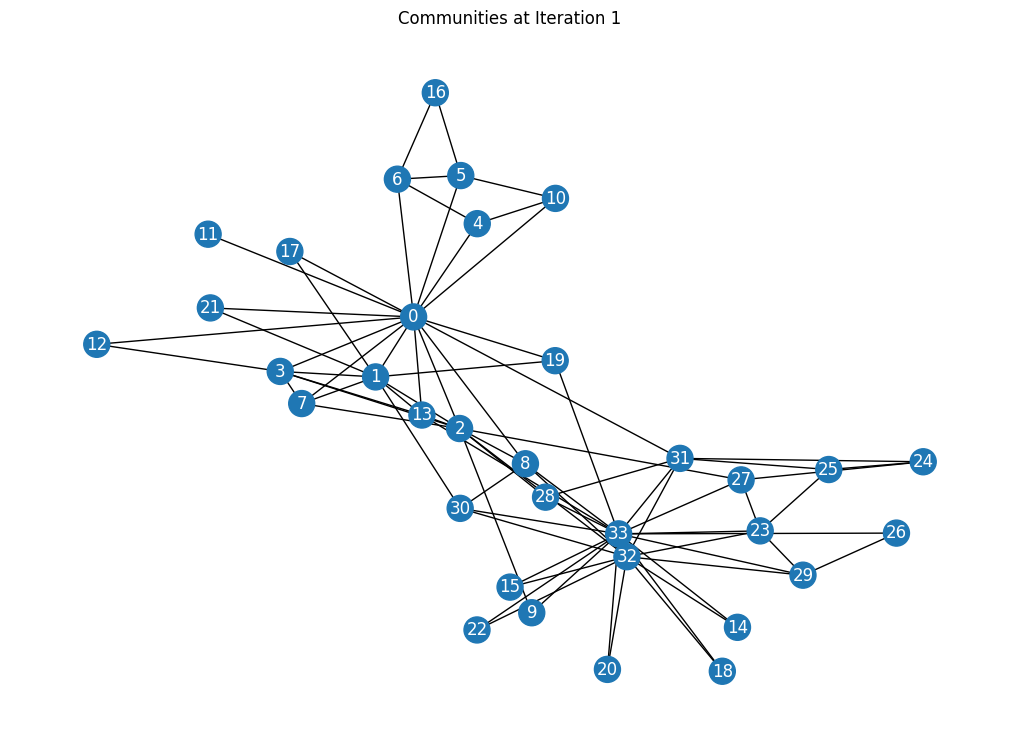

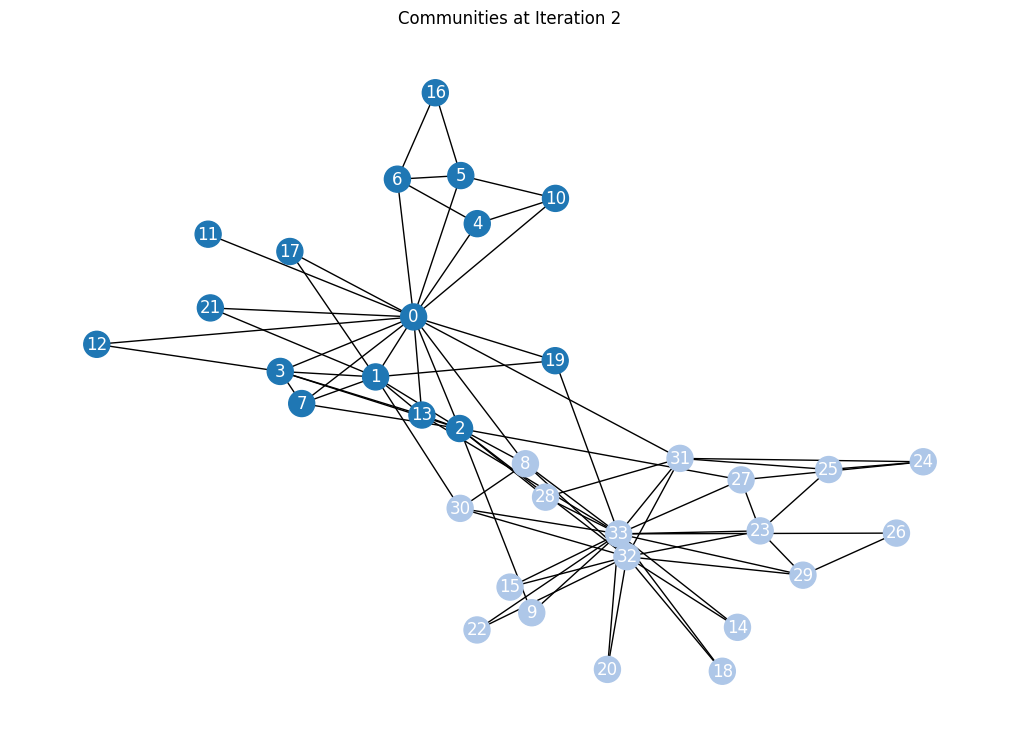

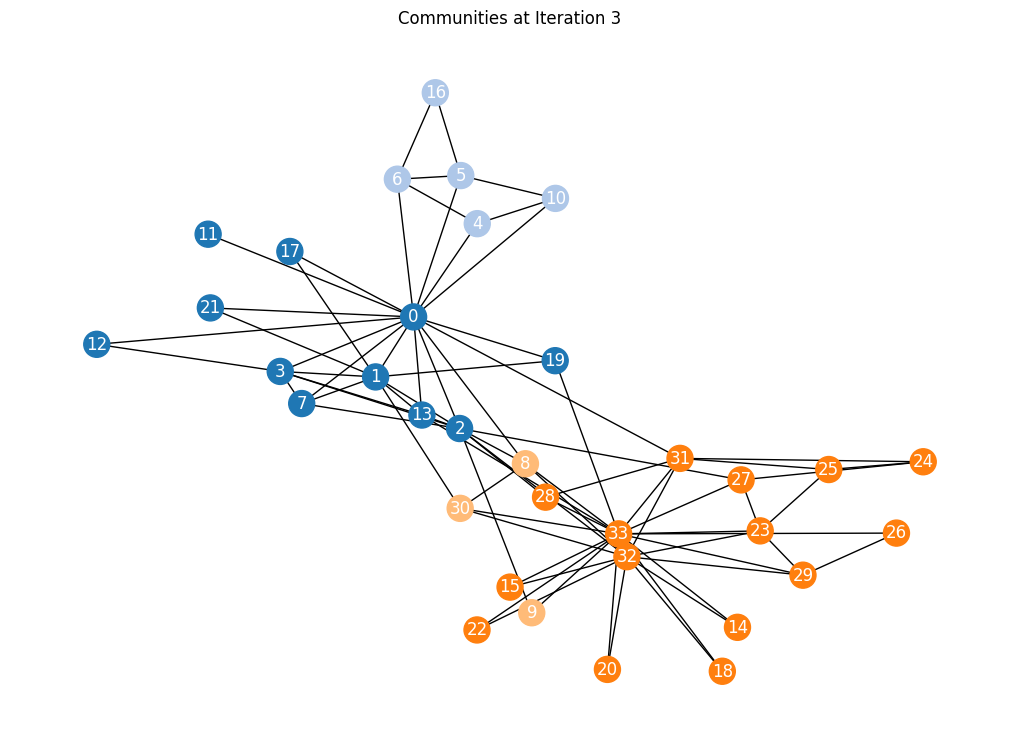


Partitioning completed in 3 iterations.
Final number of communities: 4

Community 1: [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
Community 2: [4, 5, 6, 10, 16]
Community 3: [14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33]
Community 4: [8, 9, 30]


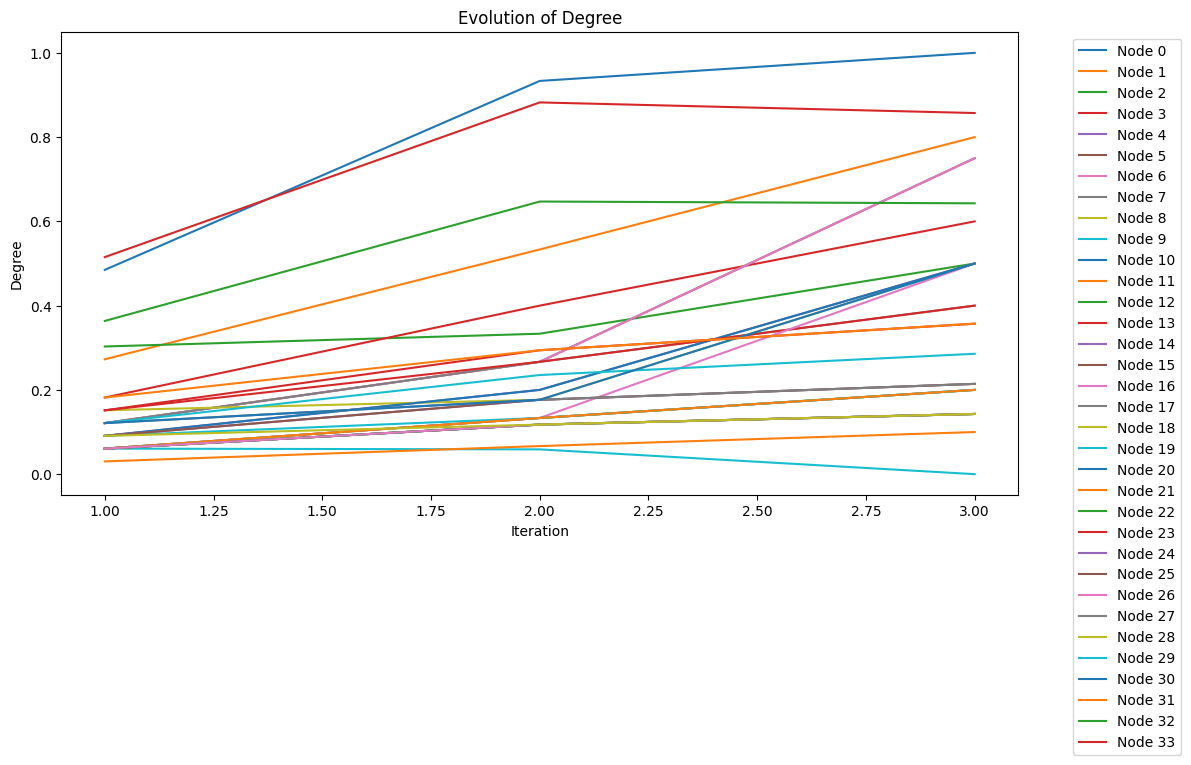

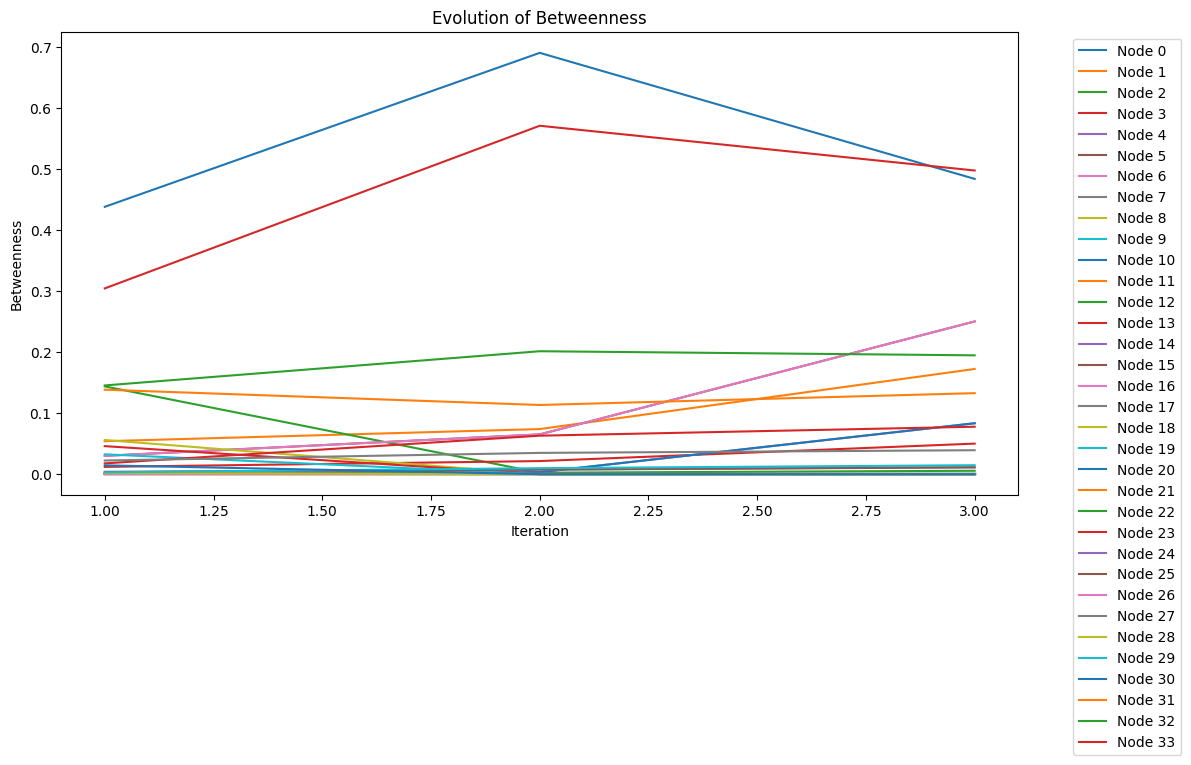

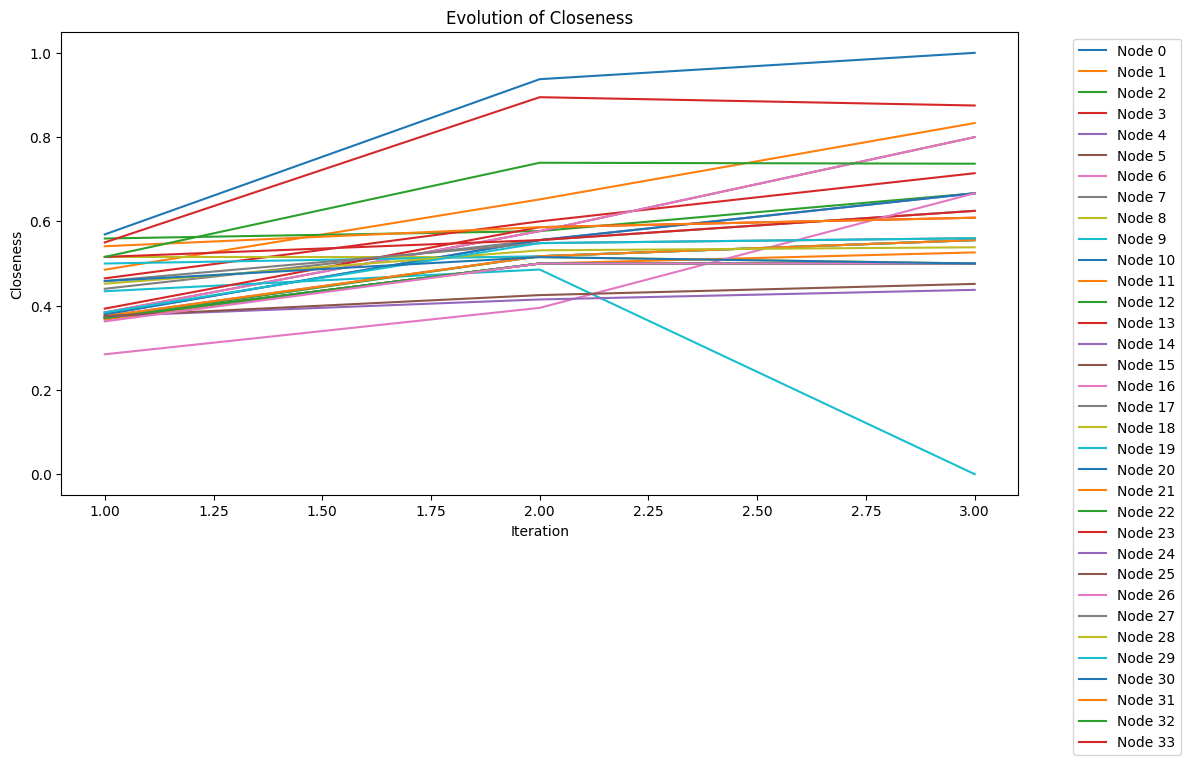

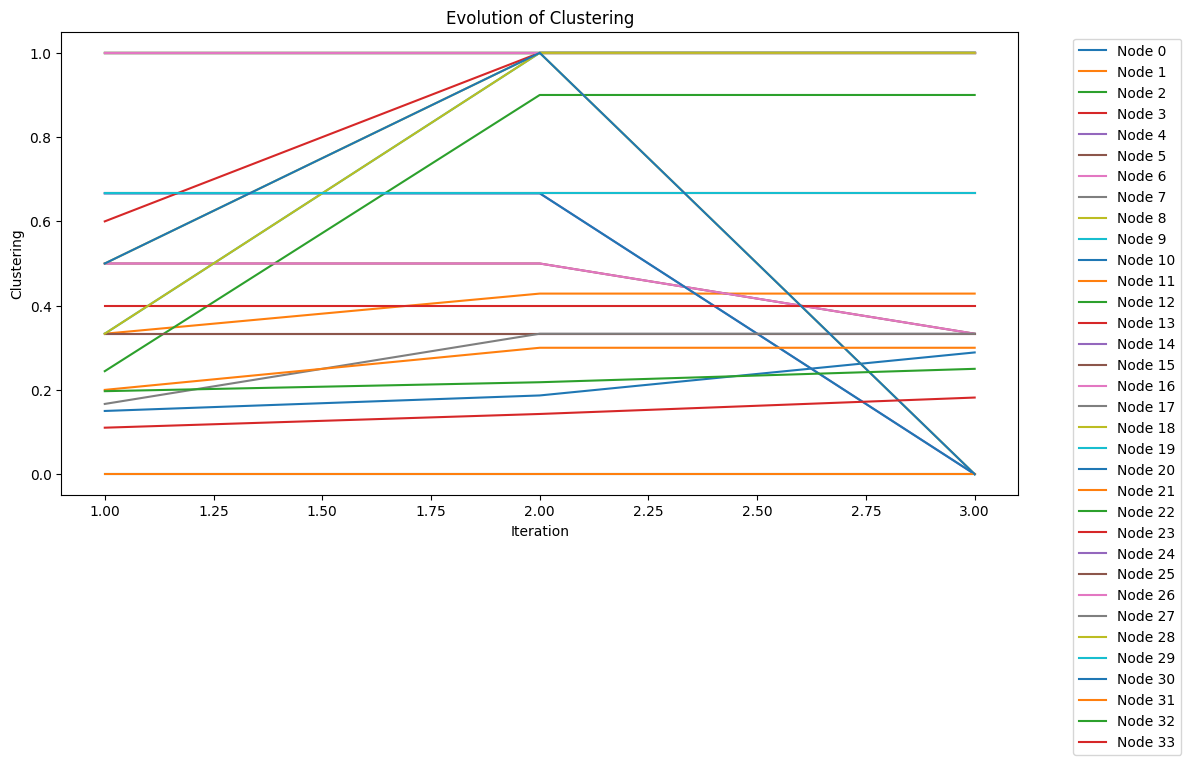

In [2]:
# ======================================================
# DSC212 - Spectral Modularity Community Detection
# Zachary's Karate Club Graph
# ======================================================

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1️⃣ Load Graph and Precompute
# ------------------------------

G = nx.karate_club_graph()
nodes = list(G.nodes())
node_map = {node_id: i for i, node_id in enumerate(nodes)}

A_full = nx.to_numpy_array(G, nodelist=nodes)
k_full = A_full.sum(axis=1)
m_full = k_full.sum() / 2.0

B_full = A_full - np.outer(k_full, k_full) / (2 * m_full)
pos = nx.spring_layout(G, seed=42)


# ------------------------------
# 2️⃣ Spectral Bipartition Function
# ------------------------------

def spectral_bipartition(community_nodes, B_full, node_map):
    # Never split tiny groups
    if len(community_nodes) <= 2:
        return "stop", [community_nodes]

    indices = [node_map[node] for node in community_nodes]
    B_C = B_full[np.ix_(indices, indices)]

    vals, vecs = np.linalg.eigh(B_C)
    lambda_max = vals[-1]
    v_max = vecs[:, -1]

    if lambda_max <= 1e-10:
        return "stop", [community_nodes]

    group1 = [community_nodes[i] for i in range(len(v_max)) if v_max[i] >= 0]
    group2 = [community_nodes[i] for i in range(len(v_max)) if v_max[i] < 0]

    # Avoid small group splits
    if len(group1) <= 2 or len(group2) <= 2:
        return "stop", [community_nodes]

    return "split", [group1, group2]


# ------------------------------
# 3️⃣ Metrics
# ------------------------------

def compute_metrics_for_partition(G, partition):
    metrics = []

    for cid, comm_nodes in enumerate(partition, start=1):
        S = G.subgraph(comm_nodes)

        if len(S) > 1:
            deg = nx.degree_centrality(S)
            bet = nx.betweenness_centrality(S)
            clo = nx.closeness_centrality(S)
        else:
            node = list(S.nodes())[0]
            deg = {node: 0}
            bet = {node: 0}
            clo = {node: 0}

        clust = nx.clustering(S)

        for node in comm_nodes:
            metrics.append({
                "node": node,
                "community": cid,
                "degree": deg[node],
                "betweenness": bet[node],
                "closeness": clo[node],
                "clustering": clust[node],
            })

    return metrics


# ------------------------------
# 4️⃣ Plot Communities
# ------------------------------

def plot_communities(G, pos, partition, title):
    colors = plt.cm.tab20.colors
    colormap = {}

    for i, comm in enumerate(partition):
        for node in comm:
            colormap[node] = colors[i % 20]

    node_colors = [colormap[n] for n in G.nodes()]

    plt.figure(figsize=(10, 7))
    nx.draw(G, pos, node_color=node_colors, with_labels=True,
            node_size=350, font_color="white")
    plt.title(title)
    plt.show()


# ------------------------------
# 5️⃣ Plot Metric Evolution
# ------------------------------

def plot_metric_evolution(metrics_history_all, metric_name, nodes):
    plt.figure(figsize=(12, 7))

    for node in nodes:
        values = []
        for it in metrics_history_all:
            data = next((m for m in it["metrics"] if m["node"] == node), None)
            values.append(data[metric_name] if data else 0)

        plt.plot(range(1, len(values) + 1), values, label=f"Node {node}")

    plt.title(f"Evolution of {metric_name.capitalize()}")
    plt.xlabel("Iteration")
    plt.ylabel(metric_name.capitalize())
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


# ------------------------------
# 6️⃣ Main Loop
# ------------------------------

pending_queue = [list(G.nodes())]
final_communities = []
iteration = 0
metrics_history_all = []

while pending_queue:
    iteration += 1

    current_partition = final_communities + pending_queue

    metrics = compute_metrics_for_partition(G, current_partition)
    metrics_history_all.append({"iteration": iteration, "metrics": metrics})

    plot_communities(G, pos, current_partition,
                     f"Communities at Iteration {iteration}")

    next_queue = []

    for comm in pending_queue:
        status, groups = spectral_bipartition(comm, B_full, node_map)
        if status == "stop":
            final_communities.extend(groups)
        else:
            next_queue.extend(groups)

    pending_queue = next_queue


print("\n============================================")
print(f"Partitioning completed in {iteration} iterations.")
print(f"Final number of communities: {len(final_communities)}")
print("============================================\n")

for cid, comm in enumerate(final_communities, start=1):
    print(f"Community {cid}: {comm}")


# ------------------------------
# 7️⃣ Plot metric evolution
# ------------------------------

for metric in ["degree", "betweenness", "closeness", "clustering"]:
    plot_metric_evolution(metrics_history_all, metric, nodes)
